# Imports

In [ ]:
import requests
import csv
from bs4 import BeautifulSoup
import yfinance as yf
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import math
import warnings
warnings.simplefilter("ignore", UserWarning)
import time

# Analytics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statistics import mean
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

# ARIMA libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import statsmodels.tsa.arima.model
# from pmdarima.arima import auto_arima

# # LSTM libraries
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, LSTM
# import keras
# from tensorflow.keras.models import save_model
# from tensorflow.keras.models import model_from_json
# from kerastuner.tuners import RandomSearch
# from keras.metrics import RootMeanSquaredError
# from kerastuner.engine.hyperparameters import HyperParameter
# import kerastuner

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio


# Data Gathering

## SP500 Tickers

In [ ]:
def save_sp500_tickers():
  # Retrieves S&P 500 table from Wikipedia
  URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
  res = requests.get(URL)
  soup = BeautifulSoup(res.content, 'lxml')
  table = soup.find('table', {'class': 'wikitable sortable'})

  # Parses the table to a list of ticker symbols
  sp500tickers = []

  for row in table.findAll('tr')[1:]:
      ticker = row.findAll('td')[0].text.strip()
      sp500tickers.append(ticker)

  # Writing to csv
  filename = "sp500tickers.csv"
  with open(filename, mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['Ticker'])
      for ticker in sp500tickers:
          writer.writerow([ticker])

  return sp500tickers

In [ ]:
def load_sp500_tickers():
  path = r'https://raw.githubusercontent.com/jakem08/ms2/main/sp500tickers.csv'
  df = pd.read_csv(path)
  ticker_list = df['Ticker'].tolist()

  return ticker_list


## Stock Data

In [ ]:
def save_stock_data(tickers, start_date, end_date):
  # yahoo finance bulk api call
  data = yf.download(tickers, start=start_date, end=end_date)
  open_df = data.loc[:, 'Open']
  high_df = data.loc[:, 'High']
  low_df = data.loc[:, 'Low']
  close_df = data.loc[:, 'Close']
  adj_close_df = data.loc[:, 'Adj Close']
  volume_df = data.loc[:, 'Volume']

  # yahoo finance individual stock .info
  desc_df = pd.DataFrame()
  for ticker in tqdm(tickers):
    stock_data = yf.Ticker(ticker)
    info = pd.DataFrame([stock_data.info])
    info.index = [ticker]
    desc_df = pd.concat([desc_df,info], axis=0)
    time.sleep(.1)

  # save dataframes to csv
  dataframe_list = [open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df]
  names = ['open_df', 'high_df', 'low_df', 'close_df', 'adj_close_df', 'volume_df','desc_df']

  for name, df in zip(names, dataframe_list):
    df.to_csv(f'{name}.csv', index=True)

  return open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df

In [ ]:
def load_stock_data():
  names = ['open_df', 'high_df', 'low_df', 'close_df', 'adj_close_df', 'volume_df', 'desc_df']
  stock_data = {name: pd.read_csv(f'https://raw.githubusercontent.com/jakem08/ms2/main/{name}.csv',index_col=0) for name in names}
  for df in stock_data.values():
        df.fillna(method='ffill', inplace=True)
  open_df = stock_data['open_df']
  high_df = stock_data['high_df']
  low_df = stock_data['low_df']
  close_df = stock_data['close_df']
  adj_close_df = stock_data['adj_close_df']
  volume_df = stock_data['volume_df']
  desc_df = stock_data['desc_df']

  return open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df


# Save or Load Data

Save or Load Tickers

In [ ]:
# sp500tickers_list = save_sp500_tickers()

In [ ]:
sp500tickers_list = load_sp500_tickers()


Save or Load Stock Data

In [ ]:
# open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df = save_stock_data(sp500tickers_list, '2013-08-30', '2023-08-30')

In [ ]:
open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df = load_stock_data()

# Data Cleaning


In [ ]:
desc_df = desc_df.drop(['BF.B','BRK.B','CAT','L'], axis=0) #drop BF.B, BRK.B; all NaNs

In [ ]:

#  list relevant columns
# desc_df_column_list  = [
#   'address1', 'city', 'state', 'zip', 'country', 'phone', 'website', 'industry',
#   'industryDisp', 'sector', 'sectorDisp', 'longBusinessSummary',
#   'fullTimeEmployees', 'companyOfficers', 'auditRisk', 'boardRisk',
#   'compensationRisk', 'shareHolderRightsRisk', 'overallRisk',
#   'governanceEpochDate', 'compensationAsOfEpochDate', 'maxAge', 'priceHint',
#   'previousClose', 'open', 'dayLow', 'dayHigh', 'regularMarketPreviousClose',
#   'regularMarketOpen', 'regularMarketDayLow', 'regularMarketDayHigh',
#   'dividendRate', 'dividendYield', 'exDividendDate', 'fiveYearAvgDividendYield',
#   'beta', 'forwardPE', 'volume', 'regularMarketVolume', 'averageVolume',
#   'averageVolume10days', 'averageDailyVolume10Day', 'bid', 'ask', 'bidSize',
#   'askSize', 'marketCap', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh',
#   'priceToSalesTrailing12Months', 'fiftyDayAverage', 'twoHundredDayAverage',
#   'trailingAnnualDividendRate', 'trailingAnnualDividendYield', 'currency',
#   'enterpriseValue', 'profitMargins', 'floatShares', 'sharesOutstanding',
#   'sharesShort', 'sharesShortPriorMonth', 'sharesShortPreviousMonthDate',
#   'dateShortInterest', 'sharesPercentSharesOut', 'heldPercentInsiders',
#   'heldPercentInstitutions', 'shortRatio', 'shortPercentOfFloat',
#   'impliedSharesOutstanding', 'bookValue', 'priceToBook', 'lastFiscalYearEnd',
#   'nextFiscalYearEnd', 'mostRecentQuarter', 'netIncomeToCommon', 'trailingEps',
#   'forwardEps', 'lastSplitFactor', 'lastSplitDate', 'enterpriseToRevenue',
#   'enterpriseToEbitda', '52WeekChange', 'SandP52WeekChange', 'lastDividendValue',
#   'lastDividendDate', 'exchange', 'quoteType', 'symbol', 'underlyingSymbol',
#   'shortName', 'longName', 'firstTradeDateEpochUtc', 'timeZoneFullName',
#   'timeZoneShortName', 'uuid', 'messageBoardId', 'gmtOffSetMilliseconds',
#   'currentPrice', 'recommendationKey', 'totalCash', 'totalCashPerShare',
#   'ebitda', 'totalDebt', 'quickRatio', 'currentRatio', 'totalRevenue',
#   'debtToEquity', 'revenuePerShare', 'returnOnAssets', 'returnOnEquity',
#   'grossProfits', 'freeCashflow', 'operatingCashflow', 'revenueGrowth',
#   'grossMargins', 'ebitdaMargins', 'operatingMargins', 'financialCurrency',
#   'trailingPegRatio', 'address2', 'payoutRatio', 'trailingPE',
#   'earningsQuarterlyGrowth', 'pegRatio', 'targetHighPrice', 'targetLowPrice',
#   'targetMeanPrice', 'targetMedianPrice', 'recommendationMean',
#   'numberOfAnalystOpinions', 'earningsGrowth', 'fax', 'industryKey',
#   'sectorKey', 'industrySymbol'
#   ]

cols = [
    # 'sector',
    'beta',
    'forwardPE',
    'marketCap',
    'priceToSalesTrailing12Months',
    'heldPercentInstitutions',
    'shortPercentOfFloat',
    'priceToBook',
    'enterpriseToEbitda',
    # 'quickRatio',
    # 'currentRatio',
    'debtToEquity',
    # 'returnOnAssets',
    'returnOnEquity',
    'pegRatio',
    'totalDebt',
    'bookValue',
    'sharesOutstanding',
    'currentPrice',
    'enterpriseValue',
    'ebitda',
    'netIncomeToCommon',


]
# 3 factor fama-french
cols = ['beta','marketCap','priceToBook' ]
fund_df = desc_df[cols]
# combined_desc = combined_desc.merge(fake_model_results_df, left_index=True, right_index=True)
fund_df.head()

,beta,marketCap,priceToBook
MMM,0.968188,5.158917e+10,6.615700
AOS,1.286998,9.849636e+09,5.215971
ABT,0.673236,1.657789e+11,4.459434
ABBV,0.547026,2.702821e+11,21.005487
ACN,1.215421,1.984690e+11,7.828382


## Missing Values

In [ ]:
rows_with_na  = fund_df[fund_df.isna().any(axis=1)]
rows_with_na.info()
fund_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   beta         0 non-null      float64
 1   marketCap    0 non-null      float64
 2   priceToBook  0 non-null      float64
dtypes: float64(3)
memory usage: 0.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, MMM to ZTS
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   beta         499 non-null    float64
 1   marketCap    499 non-null    float64
 2   priceToBook  499 non-null    float64
dtypes: float64(3)
memory usage: 15.6+ KB


<ipython-input-72-4e797fca29a3>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-72-4e797fca29a3>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



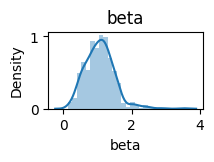

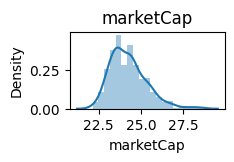

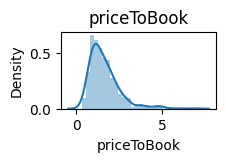

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fund_df['marketCap'] = fund_df['marketCap'].apply(lambda x: np.log(x + 1))
fund_df['priceToBook'] = fund_df['priceToBook'].apply(lambda x: np.log(x + 1))

for column in fund_df.columns:
    plt.figure(figsize=(2, 1))  # Set figure size
    sns.distplot(fund_df[column].dropna())  # Drop NaN values for visualization
    plt.title(column)
    plt.show()

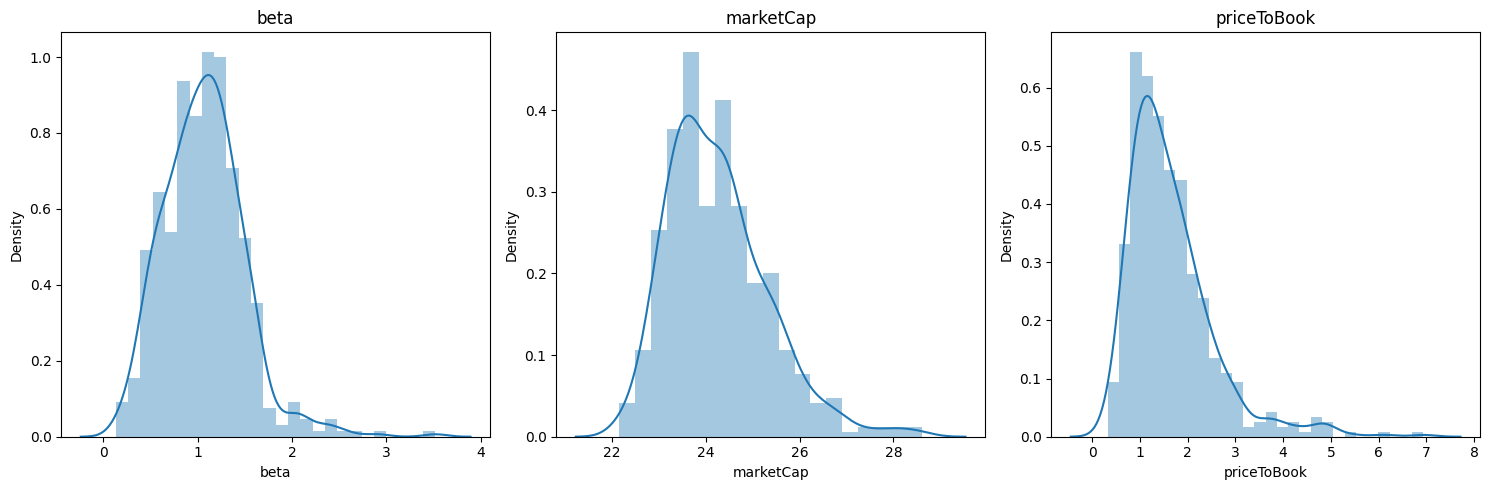

In [ ]:

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=len(fund_df.columns), figsize=(15, 5))

# Plot data
for ax, column in zip(axs, fund_df.columns):
    sns.distplot(fund_df[column].dropna(), ax=ax)
    ax.set_title(column)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
fund_df.dropna(inplace=True)
scaler = StandardScaler()
stocks_normalized = scaler.fit_transform(fund_df)

<ipython-input-74-3297bf5f0057>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
stocks_normalized = pd.DataFrame(stocks_normalized)

## Elbow Method


In [ ]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 12):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42,n_init='auto')
    kmeans.fit(stocks_normalized)  # 'data' is your dataset
    wcss.append(kmeans.inertia_)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, 12)),
    y=wcss,
    mode='lines+markers',
    marker=dict(
        color='blue',
        size=8,
        line=dict(
            color='blue',
            width=2
        )
    ),
    line=dict(
        color='blue',
        width=2,
        dash='dash'
    ),
    name='WCSS'
))

fig.update_layout(
    title='KMeans Elbow Graph for Stocks Data',
    xaxis=dict(
        title='Number of clusters',
        tickmode='linear',
        tick0=1,
        dtick=1
    ),
    yaxis=dict(
        title='WCSS'
    ),
    showlegend=True
)

fig.show()

Silhouette Score:

In [ ]:
scores = []
for n_clusters in range(2, 12):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42,n_init='auto')
    kmeans.fit(stocks_normalized)
    labels = kmeans.labels_
    score = silhouette_score(stocks_normalized, labels)
    scores.append(score)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(2, 12)),
    y=scores,
    mode='lines+markers',
    marker=dict(
        color='red',
        size=8,
        line=dict(
            color='red',
            width=2
        )
    ),
    line=dict(
        color='red',
        width=2,
        dash='dash'
    ),
    name='Silhouette Score'
))

fig.update_layout(
    title='Silhouette Score vs. Number of Clusters',
    xaxis=dict(
        title='Number of clusters',
        tickmode='linear',
        tick0=2,
        dtick=1
    ),
    yaxis=dict(
        title='Silhouette Score'
    ),
    showlegend=True
)

fig.show()


In [ ]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=('KMeans Elbow Graph for Stocks Data', 'Silhouette Score vs. Number of Clusters'))

fig.add_trace(
    go.Scatter(
        x=list(range(1, 12)),
        y=wcss,
        mode='lines+markers',
        marker=dict(
            color='blue',
            size=8,
            line=dict(
                color='blue',
                width=2
            )
        ),
        line=dict(
            color='blue',
            width=2,
            dash='dash'
        ),
        name='WCSS'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=list(range(2, 12)),
        y=scores,
        mode='lines+markers',
        marker=dict(
            color='red',
            size=8,
            line=dict(
                color='red',
                width=2
            )
        ),
        line=dict(
            color='red',
            width=2,
            dash='dash'
        ),
        name='Silhouette Score'
    ),
    row=1, col=2
)

fig.update_layout(
    title={
        'text': 'KMeans Elbow Graph and Silhouette Score vs. Number of Clusters',
        'x': 0.5,  # Center title horizontally
        'xanchor': 'center',
    },
    xaxis1=dict(
        title='Number of clusters',
        tickmode='linear',
        tick0=1,
        dtick=1
    ),
    yaxis1=dict(
        title='WCSS'
    ),
    xaxis2=dict(
        title='Number of clusters',
        tickmode='linear',
        tick0=2,
        dtick=1
    ),
    yaxis2=dict(
        title='Silhouette Score'
    ),
    showlegend=True,
    width=1200,
)

fig.show()


In [ ]:
# Plot KMeans Elbow Graph
fig1 = go.Figure()
fig1.add_trace(
    go.Scatter(
        x=list(range(1, 12)),
        y=wcss,
        mode='lines+markers',
        marker=dict(
            color='blue',
            size=8,
            line=dict(
                color='blue',
                width=2
            )
        ),
        line=dict(
            color='blue',
            width=2,
            dash='dash'
        ),
        name='WCSS'
    )
)
fig1.update_layout(
    title={
        'text': 'KMeans Elbow Graph for Stocks Data',
        'x': 0.5,
        'xanchor': 'center',
    },
    xaxis_title='Number of clusters',
    yaxis_title='WCSS',
    showlegend=True,
    width=600,
    height=400,
)
fig1.show()

# Plot Silhouette Score vs. Number of Clusters
fig2 = go.Figure()
fig2.add_trace(
    go.Scatter(
        x=list(range(2, 12)),
        y=scores,
        mode='lines+markers',
        marker=dict(
            color='red',
            size=8,
            line=dict(
                color='red',
                width=2
            )
        ),
        line=dict(
            color='red',
            width=2,
            dash='dash'
        ),
        name='Silhouette Score'
    )
)
fig2.update_layout(
    title={
        'text': 'Silhouette Score vs. Number of Clusters',
        'x': 0.5,
        'xanchor': 'center',
    },
    xaxis_title='Number of clusters',
    yaxis_title='Silhouette Score',
    showlegend=True,
    width=600,
    height=400,
)
fig2.show()


In [ ]:
optimal_clusters = 7
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42,n_init='auto')
cluster_pred_kmeans = kmeans.fit_predict(stocks_normalized)
centroids = kmeans.cluster_centers_

# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1, min_samples=5)
cluster_pred_dbscan = dbscan.fit_predict(stocks_normalized)

In [ ]:


eps_values = np.arange(0.1, 2.0, 0.1)
min_samples_values = np.arange(5, 50, 5)

# Initialize variables to store the best parameters and the best silhouette score
best_eps = None
best_min_samples = None
best_silhouette_score = -1

# Perform grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(stocks_normalized)
        if len(set(labels)) > 1:  # Exclude cases where all points are assigned to the same cluster
            silhouette_avg = silhouette_score(stocks_normalized, labels)
            if silhouette_avg > best_silhouette_score:
                best_eps = eps
                best_min_samples = min_samples
                best_silhouette_score = silhouette_avg


print("Best eps: ", best_eps)
print("Best min_samples: ", best_min_samples)
print("Best Silhouette Score: ", best_silhouette_score)

Best eps:  1.9000000000000001
Best min_samples:  5
Best Silhouette Score:  0.6206198088684293


In [ ]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score



best_eps_db = None
best_min_samples_db = None
best_db_score = float('inf')

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(stocks_normalized)
        if len(set(labels)) > 1:
            db_score = davies_bouldin_score(stocks_normalized, labels)
            if db_score < best_db_score:  # We aim for a lower Davies-Bouldin score
                best_eps_db = eps
                best_min_samples_db = min_samples
                best_db_score = db_score

print("Davies-Bouldin Index")
print("---------------------")
print("Best eps: ", best_eps_db)
print("Best min_samples: ", best_min_samples_db)
print("Best Davies-Bouldin Score: ", best_db_score)
print("\n")

# Using Calinski-Harabasz Index

best_eps_ch = None
best_min_samples_ch = None
best_ch_score = -1  # higher is better for Calinski-Harabasz

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(stocks_normalized)
        if len(set(labels)) > 1:
            ch_score = calinski_harabasz_score(stocks_normalized, labels)
            if ch_score > best_ch_score:  # higher Calinski-Harabasz score
                best_eps_ch = eps
                best_min_samples_ch = min_samples
                best_ch_score = ch_score

print("Calinski-Harabasz Index")
print("-----------------------")
print("Best eps: ", best_eps_ch)
print("Best min_samples: ", best_min_samples_ch)
print("Best Calinski-Harabasz Score: ", best_ch_score)


Davies-Bouldin Index
---------------------
Best eps:  1.9000000000000001
Best min_samples:  5
Best Davies-Bouldin Score:  1.098918031663298


Calinski-Harabasz Index
-----------------------
Best eps:  0.8
Best min_samples:  45
Best Calinski-Harabasz Score:  125.476901145774


In [ ]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
agg_labels = agg_clustering.fit_predict(stocks_normalized)

In [ ]:
fund_df['KMeans_Cluster'] = cluster_pred_kmeans
fund_df['DBSCAN_Cluster'] = cluster_pred_dbscan
fund_df['AGG_Cluster'] = agg_labels

<ipython-input-87-f823f1b1f8ae>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-87-f823f1b1f8ae>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-87-f823f1b1f8ae>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fund_df

,beta,marketCap,priceToBook,KMeans_Cluster,DBSCAN_Cluster,AGG_Cluster
MMM,0.968188,24.666578,2.030212,4,0,6
AOS,1.286998,23.010700,1.827122,1,0,1
ABT,0.673236,25.833921,1.697345,0,0,4
ABBV,0.547026,26.322732,3.091292,6,0,4
ACN,1.215421,26.013899,2.177972,6,0,4
...,...,...,...,...,...,...
YUM,1.010373,24.254911,1.161880,2,0,2
ZBRA,1.668049,23.174086,1.584302,1,0,1
ZBH,1.035269,23.865038,1.054091,1,0,1
ZION,1.141078,22.315348,0.700447,1,0,1


In [ ]:
import pandas as pd
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

# List of cluster labels
clusters = ['KMeans_Cluster', 'DBSCAN_Cluster', 'AGG_Cluster']

# Initialize empty DataFrame
un_eval_df = pd.DataFrame(columns=['Cluster', 'Davies-Bouldin Score', 'Silhouette Score', 'Calinski-Harabasz Index'])

# Loop through each cluster
for cluster in clusters:
    # Calculate metrics
    db_score = davies_bouldin_score(fund_df[['beta', 'marketCap', 'priceToBook']], fund_df[cluster])
    silhouette = silhouette_score(fund_df[['beta', 'marketCap', 'priceToBook']], fund_df[cluster])
    calinski = calinski_harabasz_score(fund_df[['beta', 'marketCap', 'priceToBook']], fund_df[cluster])

    # Append to DataFrame
    un_eval_df = un_eval_df.append({'Cluster': cluster,
                                    'Davies-Bouldin Score': db_score,
                                    'Silhouette Score': silhouette,
                                    'Calinski-Harabasz Index': calinski},
                                   ignore_index=True)
    un_eval_df = un_eval_df.round(2)
# Display results
display(un_eval_df)

<ipython-input-89-570f5575b3d5>:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-89-570f5575b3d5>:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-89-570f5575b3d5>:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Cluster,Davies-Bouldin Score,Silhouette Score,Calinski-Harabasz Index
0,KMeans_Cluster,1.30,0.21,194.35
1,DBSCAN_Cluster,2.14,0.50,48.09
2,AGG_Cluster,1.29,0.18,146.39


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=list(un_eval_df.columns),
                fill_color='darkblue',
                font_color='white',
                align='center'),
    cells=dict(values=[un_eval_df[k].tolist() for k in un_eval_df.columns],
               fill_color='lavender',
               align='center'))
])

fig.update_layout(
    title={
        'text': 'Cluster Evaluation Metrics',
        'x': 0.5,
        'xanchor': 'center',
        'font': {
            'size': 20,
            'color': 'black',
            'family': "Arial, sans-serif",
        },
    },
    width=700,
)


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=('Davies-Bouldin Score', 'Silhouette Score', 'Calinski-Harabasz Index')
)

# Davies-Bouldin Score
fig.add_trace(
    go.Bar(
        x=un_eval_df['Cluster'],
        y=un_eval_df['Davies-Bouldin Score'],
        name='Davies-Bouldin Score',
        marker_color='darkblue'
    ),
    row=1, col=1
)

# Silhouette Score
fig.add_trace(
    go.Bar(
        x=un_eval_df['Cluster'],
        y=un_eval_df['Silhouette Score'],
        name='Silhouette Score',
        marker_color='darkred'
    ),
    row=1, col=2
)

# Calinski-Harabasz Index
fig.add_trace(
    go.Bar(
        x=un_eval_df['Cluster'],
        y=un_eval_df['Calinski-Harabasz Index'],
        name='Calinski-Harabasz Index',
        marker_color='darkgreen'
    ),
    row=1, col=3
)

fig.update_layout(

    title={
        'text': 'Comparing Clustering Methods Across Different Metrics',
        'x': 0.5,  # Center title horizontally
        'xanchor': 'center',
    },
    showlegend=False,
    width=800,
)

fig.show()


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create 3D scatter plot for KMeans clusters
trace1 = go.Scatter3d(
    x=fund_df['beta'],
    y=fund_df['marketCap'],
    z=fund_df['priceToBook'],
    mode='markers',
    marker=dict(
        size=5,
        color=fund_df['KMeans_Cluster'],
        colorscale='rainbow',
        opacity=0.8,
        showscale=True,
        colorbar=dict(title='Cluster')
    )
)

# Create 3D scatter plot for DBSCAN clusters
trace2 = go.Scatter3d(
    x=fund_df['beta'],
    y=fund_df['marketCap'],
    z=fund_df['priceToBook'],
    mode='markers',
    marker=dict(
        size=5,
        color=fund_df['DBSCAN_Cluster'],
        colorscale='rainbow',
        opacity=0.8,
        showscale=True,
        colorbar=dict(title='Cluster')
    )
)

# Create 3D scatter plot for Agglomerative Clustering clusters
trace3 = go.Scatter3d(
    x=fund_df['beta'],
    y=fund_df['marketCap'],
    z=fund_df['priceToBook'],
    mode='markers',
    marker=dict(
        size=5,
        color=agg_labels,
        colorscale='rainbow',
        opacity=0.8,
        showscale=True,
        colorbar=dict(title='Cluster')
    )
)

# Create subplot
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('KMeans Clustering', 'DBSCAN Clustering', 'Agglomerative Clustering'),
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]]
)

# Add traces to subplot
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.add_trace(trace3, row=1, col=3)

# Update layout
fig.update_layout(
    title_text='3D Clustering Visualization',
    scene=dict(
        xaxis_title='Beta',
        yaxis_title='Market Cap',
        zaxis_title='Price to Book',
    ),
    height=800,
    width=2600,
    showlegend=False
)
# Update axis labels for each subplot
fig.update_scenes(
    dict(
        xaxis_title='Beta',
        yaxis_title='Market Cap',
        zaxis_title='Price to Book',
    ),
    row=1, col=1
)

fig.update_scenes(
    dict(
        xaxis_title='Beta',
        yaxis_title='Market Cap',
        zaxis_title='Price to Book',
    ),
    row=1, col=2
)

fig.update_scenes(
    dict(
        xaxis_title='Beta',
        yaxis_title='Market Cap',
        zaxis_title='Price to Book',
    ),
    row=1, col=3
)

# Show plot
fig.show()


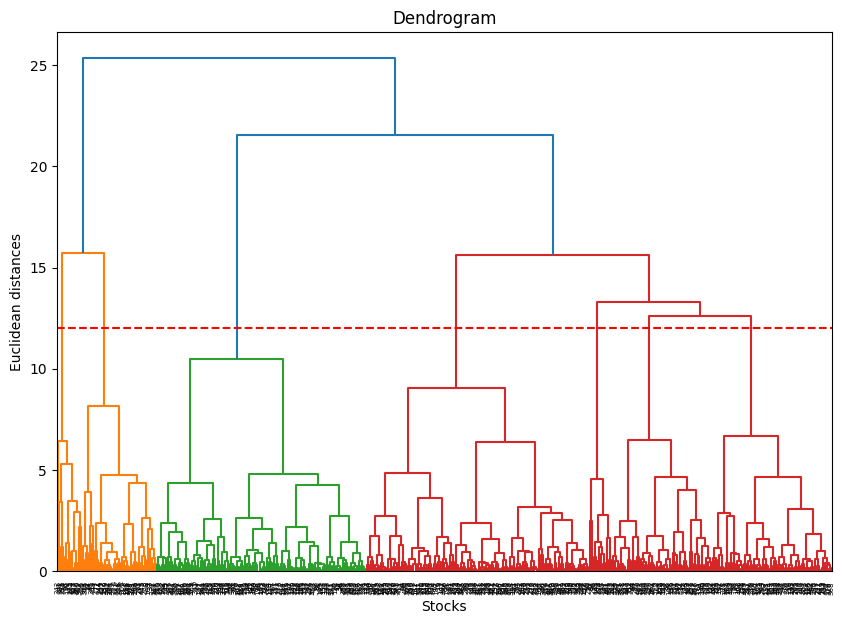

In [ ]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(stocks_normalized, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Stocks')
plt.ylabel('Euclidean distances')
plt.axhline(y=12, color='r', linestyle='--')
plt.show()

In [ ]:
clustered_tickers = fund_df.groupby('KMeans_Cluster').apply(lambda x: x.index.tolist())

for cluster, tickers in clustered_tickers.items():
    print(f"Cluster {cluster}:", len(tickers) ,tickers)
    print("--------------------------------------------------")


Cluster 0: 85 ['ABT', 'ATVI', 'AFL', 'APD', 'MO', 'AXP', 'ADI', 'AJG', 'T', 'BAC', 'BDX', 'BLK', 'BA', 'BKNG', 'BSX', 'BMY', 'SCHW', 'CVX', 'CB', 'CI', 'CSCO', 'CME', 'CL', 'CMCSA', 'COP', 'CVS', 'DHR', 'DE', 'DIS', 'DUK', 'ETN', 'ELV', 'EQIX', 'XOM', 'FDX', 'FI', 'GD', 'GE', 'GILD', 'GS', 'HON', 'HUM', 'IBM', 'INTC', 'ICE', 'JPM', 'LIN', 'LMT', 'MMC', 'MCD', 'MCK', 'MDT', 'MET', 'MU', 'MDLZ', 'MS', 'NFLX', 'NEE', 'NOC', 'PCAR', 'PYPL', 'PFE', 'PM', 'PNC', 'PGR', 'PLD', 'QCOM', 'RTX', 'REGN', 'ROP', 'SPGI', 'CRM', 'SO', 'SBUX', 'SYK', 'TMUS', 'TGT', 'TXN', 'TMO', 'USB', 'UPS', 'VZ', 'VRTX', 'WFC', 'WELL']
--------------------------------------------------
Cluster 1: 123 ['AOS', 'ALK', 'ALB', 'ALLE', 'AAL', 'AIG', 'BBWI', 'BBY', 'TECH', 'BK', 'BWA', 'BXP', 'COF', 'KMX', 'CTLT', 'CBRE', 'CE', 'CDAY', 'CF', 'CRL', 'CFG', 'CTSH', 'CMA', 'GLW', 'CMI', 'DAL', 'XRAY', 'DFS', 'DOV', 'DOW', 'DD', 'DXC', 'EMN', 'EBAY', 'EPAM', 'EQT', 'EFX', 'FFIV', 'FRT', 'FITB', 'FSLR', 'FTV', 'BEN', 'GEN', 'GN

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
X = fund_df[cols]  # Features
y = fund_df['KMeans_Cluster']  # Labels

# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)


importances = rf.feature_importances_

features = X.columns

indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
sorted_features = [features[i] for i in indices]

# # Plot the feature importances
# plt.figure(figsize=(10,6))
# plt.title('Feature Importances for Predicting Cluster Labels')
# plt.bar(range(X.shape[1]), importances[indices], align='center')
# plt.xticks(range(X.shape[1]), sorted_features, rotation=90)
# plt.xlabel('Feature')
# plt.ylabel('Importance')
# plt.tight_layout()
# plt.show()


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=[feature for feature in sorted_features],
        y=[importance for importance in importances[indices]],
        marker=dict(
            color='darkblue',
        ),
        # text=[feature for feature in sorted_features],
    )
)

fig.update_layout(

    title={
        'text': 'Feature Importances for Predicting Cluster Labels',
        'x': 0.5,  # Center title horizontally
        'xanchor': 'center',
    },
    xaxis=dict(
        title='Feature',
        tickangle=45,
        tickmode='array',
        tickvals=[feature for feature in sorted_features],
        ticktext=[feature for feature in sorted_features],
    ),
    yaxis=dict(
        title='Importance',
    ),
    showlegend=False,
    width=800,
)

fig.show()


In [ ]:
characteristics = ['beta', 'marketCap', 'priceToBook']

In [ ]:
import plotly.graph_objects as go


cluster_means = fund_df.groupby('KMeans_Cluster').mean()


fig = go.Figure()



# Add traces for bar plots
for i, char in enumerate(characteristics):
    fig.add_trace(
        go.Bar(
            x=[f'{char} - Cluster {c}' for c in cluster_means.index],
            y=cluster_means[char],
            name=char
        )
    )

# Update layout
fig.update_layout(
    title='Average Characteristics for Each Cluster',
    yaxis_title='Average Value',
    xaxis_title='Characteristic - Cluster',
    barmode='group',
    legend_title='Characteristic'
)

fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=3, subplot_titles=characteristics)

# Add traces for bar plots
for i, char in enumerate(characteristics):
    fig.add_trace(
        go.Bar(
            x=cluster_means.index,
            y=cluster_means[char],
            name=char
        ),
        row=1,
        col=i+1
    )

# Update layout
fig.update_layout(
    title_text='Average Characteristics for Each Cluster',
    title_x=0.5,
    showlegend=False,
    width=1200,
    height=600,
)


for i in range(3):
    fig['layout'][f'yaxis{i+1}']['title'] = f'Average {characteristics[i]}'
    if characteristics[i] == 'marketCap':
        fig['layout'][f'yaxis{i+1}']['range'] = [22, max(cluster_means['marketCap']+.5)]
    fig['layout'][f'xaxis{i+1}']['title'] = 'Cluster'



fig.show()

In [ ]:
def load_results_data():
  names = [
      'gbm_results',
      'arima_results',
      'xgb_results',
      'LSTM_results',
      ]
  stock_data = {name: pd.read_csv(f'https://raw.githubusercontent.com/jakem08/ms2/main/{name}.csv',index_col=0) for name in names}

  gbm_results_df = stock_data['gbm_results']
  gbm_results_df.columns = ['Ticker', 'gbm_avg_RMSE', 'gbm_avg_MAPE']
  gbm_results_df.set_index('Ticker',inplace=True)
  gbm_results_df.index.name = None

  arima_results_df = stock_data['arima_results']
  arima_results_df.columns = ['Ticker', 'arima_avg_RMSE','arima_std_RMSE', 'arima_avg_MAPE', 'arima_std_MAPE', 'arima_model_order']
  arima_results_df.set_index('Ticker',inplace=True)
  arima_results_df.index.name = None

  xgb_results_df = stock_data['xgb_results']
  xgb_results_df.columns = ['xgb_n_estimators','xgb_max_depth',	'xgb_learning_rate','xgb_avg_RMSE','xgb_std_RMSE', 'xgb_avg_MAPE', 'xgb_std_MAPE','xgb_Accuracy']

  lstm_results_df = stock_data['LSTM_results']
  lstm_results_df.columns = ['lstm_avg_RMSE', 'lstm_std_RMSE','lstm_avg_MAPE','lstm_std_MAPE','lstm_model']

  model_results_df = pd.merge(gbm_results_df, arima_results_df, how='inner', left_index=True, right_index=True)
  model_results_df = pd.merge(model_results_df, xgb_results_df, how='inner', left_index=True, right_index=True)
  model_results_df = pd.merge(model_results_df, lstm_results_df, how='inner', left_index=True, right_index=True)

  return model_results_df

model_results_df = load_results_data()

In [ ]:
model_results_df['arima_avg_RMSE'] = model_results_df['arima_avg_RMSE'] * 10
model_results_df['arima_avg_MAPE'] = model_results_df['arima_avg_MAPE'] / 100
model_results_df.to_csv('model_results.csv', index=False)

In [ ]:
RSME_results_df = model_results_df[['gbm_avg_RMSE','arima_avg_RMSE','xgb_avg_RMSE','lstm_avg_RMSE']]
RSME_results_df['RMSE_best_model'] = RSME_results_df.idxmin(axis=1)
RSME_results_df

<ipython-input-103-82c2eb1687c8>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,gbm_avg_RMSE,arima_avg_RMSE,xgb_avg_RMSE,lstm_avg_RMSE,RMSE_best_model
A,8.092,1.424,2.947717,5.767298,arima_avg_RMSE
AAL,4.820,0.226,0.986795,1.881555,arima_avg_RMSE
AAPL,7.814,1.008,1.350246,5.905118,arima_avg_RMSE
ABBV,9.310,3.068,1.264111,3.233357,xgb_avg_RMSE
ABT,4.862,1.528,0.933080,2.935337,xgb_avg_RMSE
...,...,...,...,...,...
OGN,1.745,2.445,1.031798,1.237283,xgb_avg_RMSE
OTIS,7.780,1.480,1.167703,1.831954,xgb_avg_RMSE
CEG,17.490,1.670,1.965999,8.541635,arima_avg_RMSE
GEHC,7.960,1.720,1.359106,8.539388,xgb_avg_RMSE


In [ ]:
MAPE_results_df = model_results_df[['gbm_avg_MAPE','arima_avg_MAPE','xgb_avg_MAPE','lstm_avg_MAPE']]
MAPE_results_df['MAPE_best_model'] = MAPE_results_df.idxmin(axis=1)
MAPE_results_df

<ipython-input-104-466579ff4bd2>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,gbm_avg_MAPE,arima_avg_MAPE,xgb_avg_MAPE,lstm_avg_MAPE,MAPE_best_model
A,0.084,0.030266,0.026922,0.046980,xgb_avg_MAPE
AAL,0.152,0.015904,0.029731,0.051152,arima_avg_MAPE
AAPL,0.088,0.040564,0.019526,0.052131,xgb_avg_MAPE
ABBV,0.100,0.035552,0.015979,0.039141,xgb_avg_MAPE
ABT,0.066,0.019798,0.012601,0.033981,xgb_avg_MAPE
...,...,...,...,...,...
OGN,0.050,0.018100,0.037588,0.048323,arima_avg_MAPE
OTIS,0.105,0.037735,0.013980,0.017546,xgb_avg_MAPE
CEG,0.200,0.009560,0.020709,0.077695,arima_avg_MAPE
GEHC,0.090,0.048390,0.015198,0.118323,xgb_avg_MAPE


In [ ]:
if 'XOM' in MAPE_results_df.index:
    xom_data = MAPE_results_df.loc['XOM']
    print(xom_data)
else:
    print('XOM is not in the index of MAPE_results_df')

XOM is not in the index of MAPE_results_df


In [ ]:
# Convert 'clustered_tickers' to a DataFrame with columns 'Ticker' and 'Cluster'
clustered_tickers_df = pd.DataFrame([(cluster, ticker) for cluster, tickers in clustered_tickers.items() for ticker in tickers], columns=['Cluster', 'Ticker'])

# Merge 'MAPE_results_df' with 'clustered_tickers_df' to get cluster information for each ticker
merged_df = pd.merge(MAPE_results_df, clustered_tickers_df, left_index=True, right_on='Ticker', how='right')

# Group by cluster and find the best model for each ticker
best_models = merged_df.groupby('Cluster')['MAPE_best_model'].apply(lambda x: x.mode()[0] if not x.isnull().all() else 'No Best Model')

# Map each ticker to its best model
ticker_to_best_model = dict(zip(merged_df['Ticker'], merged_df['MAPE_best_model']))

# Swap the tickers for the best model in each cluster
for cluster, best_model in best_models.items():
    tickers = clustered_tickers[cluster]
    best_model_tickers = [ticker_to_best_model.get(ticker, 'No Best Model') for ticker in tickers]
    print(f"Cluster {cluster}: {best_model_tickers}")


Cluster 0: ['xgb_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'arima_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'arima_avg_MAPE', 'arima_avg_MAPE', 'xgb_avg_MAPE', 'arima_avg_MAPE', 'arima_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'arima_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'arima_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'arima_avg_MAPE', 'arima_avg_MAPE', 'arima_avg_MAPE', 'arima_avg_MAPE', 'xgb_avg_MAPE', 'arima_avg_MAPE', nan, 'arima_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'arima_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'arima_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'arima_avg_MAPE', 'arima_avg_MAPE', 'arima_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'arima_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_MAPE', 'arima_avg_MAPE', 'arima_avg_MAPE', 'arima_avg_MAPE', 'arima_avg_MAPE', 'xgb_avg_MAPE', 'xgb_avg_

In [ ]:
# Initialize list to store data
data = []


for cluster, best_model in best_models.items():
    tickers = clustered_tickers[cluster]
    best_model_tickers = [ticker_to_best_model.get(ticker, 'No Best Model') for ticker in tickers]
    for ticker, best_model_ticker in zip(tickers, best_model_tickers):
        data.append([cluster, ticker, best_model_ticker])


df = pd.DataFrame(data, columns=['Cluster', 'Ticker', 'Best_Model_Ticker'])


display(df)


,Cluster,Ticker,Best_Model_Ticker
0,0,ABT,xgb_avg_MAPE
1,0,ATVI,xgb_avg_MAPE
2,0,AFL,xgb_avg_MAPE
3,0,APD,xgb_avg_MAPE
4,0,MO,xgb_avg_MAPE
...,...,...,...
494,6,PG,arima_avg_MAPE
495,6,TSLA,arima_avg_MAPE
496,6,UNH,arima_avg_MAPE
497,6,V,xgb_avg_MAPE


In [ ]:

grouped_df = df.groupby(['Cluster', 'Best_Model_Ticker']).size().unstack(fill_value=0)


display(grouped_df)


Best_Model_Ticker,arima_avg_MAPE,lstm_avg_MAPE,xgb_avg_MAPE
Cluster,,,
0,29,0,54
1,56,1,59
2,40,1,83
3,26,0,13
4,31,0,48
5,7,0,11
6,6,0,18


In [ ]:

percentages_df = grouped_df.div(grouped_df.sum(axis=1), axis=0) * 100

display(percentages_df)


Best_Model_Ticker,arima_avg_MAPE,lstm_avg_MAPE,xgb_avg_MAPE
Cluster,,,
0,34.939759,0.000000,65.060241
1,48.275862,0.862069,50.862069
2,32.258065,0.806452,66.935484
3,66.666667,0.000000,33.333333
4,39.240506,0.000000,60.759494
5,38.888889,0.000000,61.111111
6,25.000000,0.000000,75.000000


In [ ]:
import plotly.graph_objects as go

# Define colors for each model
colors = {
    'arima_avg_MAPE': 'darkred',
    'lstm_avg_MAPE': 'yellow',
    'xgb_avg_MAPE': 'darkblue',
}

fig = go.Figure()

# Add traces for each model
for model in percentages_df.columns:
    fig.add_trace(go.Bar(
        x=percentages_df.index,
        y=percentages_df[model],
        name=model,
        marker_color=colors[model],
    ))


fig.update_layout(
    barmode='stack',
    title={
        'text': 'Relative Percentages of Best Models in Each Cluster',
        'x': 0.5,
        'xanchor': 'center',
    },
    xaxis_title='Cluster',
    yaxis_title='Percentage',
    legend_title='Best Model',
    width=800,
    height=400,
)

# Show plot
fig.show()


In [ ]:
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

davies_bouldin_scores = []
silhouette_scores = []
calinski_harabasz_scores = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42,n_init='auto')
    labels = kmeans.fit_predict(stocks_normalized)
    davies_bouldin_scores.append(davies_bouldin_score(stocks_normalized, labels))
    silhouette_scores.append(silhouette_score(stocks_normalized, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(stocks_normalized, labels))


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=list(range(2, 15)),
        y=davies_bouldin_scores,
        mode='lines+markers',
        name='Davies Bouldin Score',
        line=dict(color='blue'),
    )
)

fig.add_trace(
    go.Scatter(
        x=list(range(2, 15)),
        y=silhouette_scores,
        mode='lines+markers',
        name='Silhouette Score',
        line=dict(color='red'),
    )
)

fig.add_trace(
    go.Scatter(
        x=list(range(2, 15)),
        y=calinski_harabasz_scores,
        mode='lines+markers',
        name='Calinski Harabasz Score',
        line=dict(color='green'),
    )
)

fig.update_layout(
    title='Cluster Validation Scores',
    xaxis=dict(title='Number of Clusters'),
    yaxis=dict(title='Score'),
    legend=dict(
        x=0.1,
        y=1,
        traceorder='normal',
        bgcolor='lightgrey',
        bordercolor='grey',
        borderwidth=0.5
    )
)

fig.show()


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=list(range(2, 15)),
        y=davies_bouldin_scores,
        mode='lines+markers',
        name='Davies Bouldin Score',
        line=dict(color='blue'),
        yaxis='y1',
    )
)

fig.add_trace(
    go.Scatter(
        x=list(range(2, 15)),
        y=silhouette_scores,
        mode='lines+markers',
        name='Silhouette Score',
        line=dict(color='red'),
        yaxis='y1',
    )
)

fig.add_trace(
    go.Scatter(
        x=list(range(2, 15)),
        y=calinski_harabasz_scores,
        mode='lines+markers',
        name='Calinski Harabasz Score',
        line=dict(color='green'),
        yaxis='y2',
    )
)

fig.update_layout(
    title='Cluster Validation Scores',
    xaxis=dict(title='Number of Clusters'),
    yaxis1=dict(
        title='Davies Bouldin & Silhouette Score',
        side='left',
    ),
    yaxis2=dict(
        title='Calinski Harabasz Score',
        side='right',
        overlaying='y1',
    ),
    legend=dict(
        x=0.1,
        y=1,
        traceorder='normal',
        bgcolor='lightgrey',
        bordercolor='grey',
        borderwidth=0.5
    )
)

fig.show()


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Davies Bouldin Score', 'Silhouette Score', 'Calinski Harabasz Score')
)

fig.add_trace(
    go.Scatter(
        x=list(range(2, 15)),
        y=davies_bouldin_scores,
        mode='lines+markers',
        name='Davies Bouldin Score',
        line=dict(color='darkblue'),
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=list(range(2, 15)),
        y=silhouette_scores,
        mode='lines+markers',
        name='Silhouette Score',
        line=dict(color='darkred'),
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=list(range(2, 15)),
        y=calinski_harabasz_scores,
        mode='lines+markers',
        name='Calinski Harabasz Score',
        line=dict(color='darkgreen'),
    ),
    row=1, col=3
)

fig.update_layout(
    title={
        'text': 'K-Means Validation Score Sensitivity Analysis',
        'x': 0.5,  # Center title horizontally
        'xanchor': 'center',
    },
    showlegend=False,
    width=1200,
    height=400,
)

fig.update_xaxes(title_text='Number of Clusters', row=1, col=1)
fig.update_xaxes(title_text='Number of Clusters', row=1, col=2)
fig.update_xaxes(title_text='Number of Clusters', row=1, col=3)

fig.update_yaxes(title_text='Score', row=1, col=1)
fig.update_yaxes(title_text='Score', row=1, col=2)
fig.update_yaxes(title_text='Score', row=1, col=3)

fig.show()
